# 导入库

In [1]:
import numpy as np
import scipy.integrate as integrate
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd


import sympy as sp

sp.init_printing(use_latex="mathjax")

# 定义常量

In [2]:
# 常量
k = 0.55 / (2 * np.pi)
velocity_head = -1
L_head = 2.86
L_body = 1.65
num_segments = 223 + 1
time_steps = 301

# 定义函数

In [3]:
# 函数
def normalize_vector(vector):
    norm = np.linalg.norm(vector)
    return vector / norm


def vector_projection(a, b):
    # 计算 a 在 b 上的投影
    projection = (np.dot(a, b) / np.dot(b, b)) * b
    return projection


def spiral_parametric(theta):
    return k * theta


def calc_position(theta):
    r = spiral_parametric(theta)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y


def tangent_vector(theta):
    x = k * (np.cos(theta) - theta * np.sin(theta))
    y = k * (np.sin(theta) + theta * np.cos(theta))
    return x, y


def ds_dtheta(theta):
    return np.sqrt(k**2 + (k * theta) ** 2)


def s_theta_numeric(theta):
    result, _ = integrate.quad(ds_dtheta, 0, theta)
    return result


def theta_s_numeric(s_value):
    def func_to_solve(theta):
        return s_theta_numeric(theta) - s_value

    try:
        theta_solution = optimize.root_scalar(
            func_to_solve,
            bracket=[0, 16 * 2 * np.pi],  # 手动调整
            method="brentq",
        )
        if not theta_solution.converged:
            raise ValueError("无法找到合适的theta值")
        return theta_solution.root
    except Exception as e:
        print("s_value:", s_value)
        print(f"Error in theta_s_numeric: {e}")
        return None


def next_theta(theta, L, max_retries=10, tolerance=1e-5, max_iter=10000):
    x_0, y_0 = calc_position(theta)

    def func_to_solve(next_theta):
        x_1, y_1 = calc_position(next_theta)
        return np.sqrt((x_1 - x_0) ** 2 + (y_1 - y_0) ** 2) - L

    step_factor = 0.5  # 用来动态调整步长的因子
    retries = 0

    while retries < max_retries:
        # 初始猜测值
        guess_1 = theta
        guess_2 = theta + 1e-5

        try:
            # 使用 secant 方法，不需要 bracket，只需要初始猜测值，并设置最大迭代次数
            solution = optimize.root_scalar(
                func_to_solve,
                x0=guess_1,
                x1=guess_2,
                method="secant",
                xtol=tolerance,
                maxiter=max_iter,  # 增加最大迭代次数
            )

            if solution.converged:
                return solution.root
            else:
                raise ValueError("Root finding did not converge")

        except Exception as e:
            print(f"Error at theta={theta}, L={L}, retry={retries + 1}: {e}")
            step_factor *= 1.5  # 扩大初始猜测值的差距
            retries += 1

    print(f"Failed to find a solution for theta={theta} after {max_retries} retries.")
    return None


def next_velocity(theta, next_theta, velocity, tolerance=1e-5, max_iter=10000):
    def func_to_solve(next_velocity):
        # 计算当前节点和下一个节点的位移向量
        x0, y0 = calc_position(theta)
        x1, y1 = calc_position(next_theta)
        dist_vector = np.array([x1 - x0, y1 - y0])

        # 当前速度在位移向量上的投影
        v0_projection = vector_projection(
            velocity * normalize_vector(tangent_vector(theta)), dist_vector
        )

        # 下一速度在位移向量上的投影
        v1_projection = vector_projection(
            next_velocity * normalize_vector(tangent_vector(next_theta)), dist_vector
        )

        # 比较两个速度的差异
        return np.linalg.norm(v0_projection) - np.linalg.norm(v1_projection)

    # 使用 `secant` 方法求解下一个速度的大小
    result = optimize.root_scalar(
        func_to_solve,
        bracket=[
            -2 * np.linalg.norm(velocity),
            0,
        ],  # 假设新的速度不会超过两倍的当前速度
        method="brentq",
        xtol=tolerance,
        maxiter=max_iter,
    )

    if result.converged:
        return result.root
    else:
        print(
            f"Failed to compute next velocity at theta={theta}, next_theta={next_theta}"
        )
        return None

# 定义变量

In [4]:
# 定义变量
# 初始化结果存储
positions = []
velocities = []

# 初始化龙头的角度和位置
theta_head = 16 * 2 * np.pi
x_head, y_head = calc_position(theta_head)

# 计算

In [5]:
# 计算
for t in range(time_steps):
    # 计算龙头的位置
    x_head, y_head = calc_position(theta_head)

    positions.append([x_head, y_head])
    velocities.append([velocity_head])

    # 计算龙身的位置
    _next_theta = theta_head
    _next_velocity = velocity_head
    for i in range(1, num_segments):
        L = L_head if i == 1 else L_body
        theta_tmp = _next_theta
        _next_theta = next_theta(_next_theta, L)
        if _next_theta is None:
            break
        x_segment, y_segment = calc_position(_next_theta)
        positions[-1].extend([x_segment, y_segment])
        _next_velocity = next_velocity(theta_tmp, _next_theta, _next_velocity)
        if _next_velocity is None:
            break
        velocities[-1].append(_next_velocity)
        # 每隔10个时间步长输出一次 (显示进度)
        if (t % 10 == 0) and (i % 10) == 0:
            print(f"t={t}, i={i}")

    # 更新龙头的角度
    theta_head = theta_s_numeric(s_theta_numeric(theta_head) + velocity_head)

t=0, i=10
t=0, i=20
t=0, i=30
t=0, i=40
t=0, i=50
t=0, i=60
t=0, i=70
t=0, i=80
t=0, i=90
t=0, i=100
t=0, i=110
t=0, i=120
t=0, i=130
t=0, i=140
t=0, i=150
t=0, i=160
t=0, i=170
t=0, i=180
t=0, i=190
t=0, i=200
t=0, i=210
t=0, i=220
t=10, i=10
t=10, i=20
t=10, i=30
t=10, i=40
t=10, i=50
t=10, i=60
t=10, i=70
t=10, i=80
t=10, i=90
t=10, i=100
t=10, i=110
t=10, i=120
t=10, i=130
t=10, i=140
t=10, i=150
t=10, i=160
t=10, i=170
t=10, i=180
t=10, i=190
t=10, i=200
t=10, i=210
t=10, i=220
t=20, i=10
t=20, i=20
t=20, i=30
t=20, i=40
t=20, i=50
t=20, i=60
t=20, i=70
t=20, i=80
t=20, i=90
t=20, i=100
t=20, i=110
t=20, i=120
t=20, i=130
t=20, i=140
t=20, i=150
t=20, i=160
t=20, i=170
t=20, i=180
t=20, i=190
t=20, i=200
t=20, i=210
t=20, i=220
t=30, i=10
t=30, i=20
t=30, i=30
t=30, i=40
t=30, i=50
t=30, i=60
t=30, i=70
t=30, i=80
t=30, i=90
t=30, i=100
t=30, i=110
t=30, i=120
t=30, i=130
t=30, i=140
t=30, i=150
t=30, i=160
t=30, i=170
t=30, i=180
t=30, i=190
t=30, i=200
t=30, i=210
t=30, i=220
t=

# 测试

## 画某个节点不同时间的位置

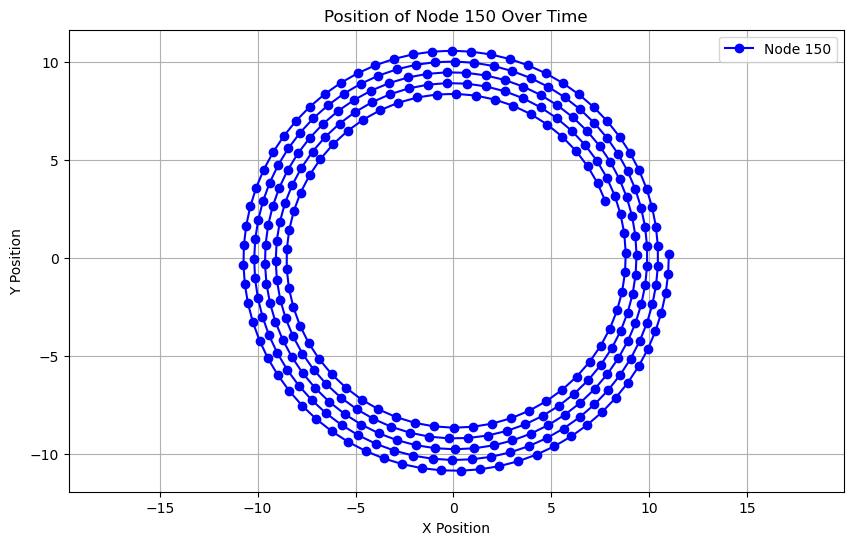

In [6]:
# 提取第 idx 个节点的坐标
idx = 150  # 0-222, 自选
x_coords = [positions[t][2 * idx] for t in range(time_steps)]
y_coords = [positions[t][2 * idx + 1] for t in range(time_steps)]

# 绘制第 idx 个节点的点线图
plt.figure(figsize=(10, 6))
plt.plot(x_coords, y_coords, marker="o", linestyle="-", color="b", label=f"Node {idx}")
plt.title(f"Position of Node {idx} Over Time")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

## 画所有节点在某个时间点的位置

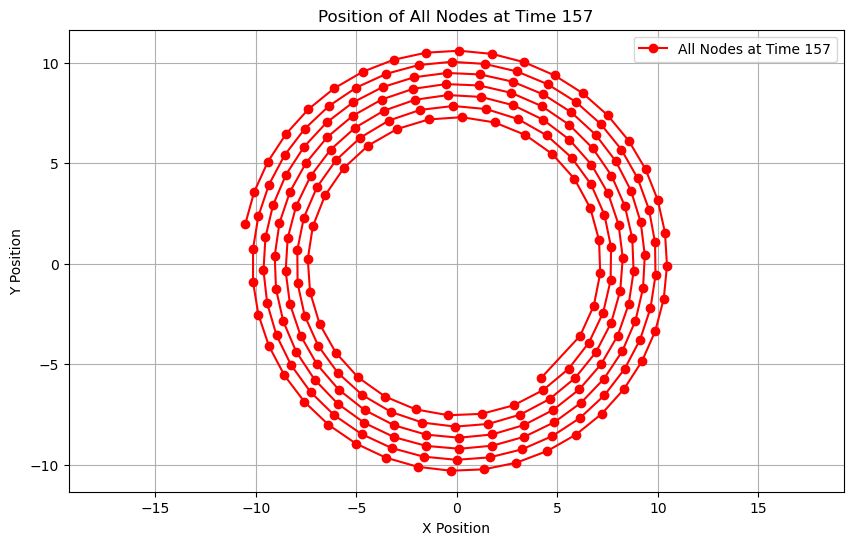

In [7]:
# 提取第 time 时间点所有节点的坐标
time = 157  # 0-300, 自选
if time < len(positions):
    x_coords_all_nodes = [positions[time][2 * i] for i in range(num_segments)]
    y_coords_all_nodes = [positions[time][2 * i + 1] for i in range(num_segments)]

    # 绘制第257时间点所有节点的位置图
    plt.figure(figsize=(10, 6))
    plt.plot(
        x_coords_all_nodes,
        y_coords_all_nodes,
        marker="o",
        linestyle="-",
        color="r",
        label=f"All Nodes at Time {time}",
    )
    plt.title(f"Position of All Nodes at Time {time}")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.legend()
    plt.grid(True)
    plt.axis("equal")
    plt.show()
else:
    print(f"Time point {time} exceeds available data.")

## 绘制龙的轨迹的动画

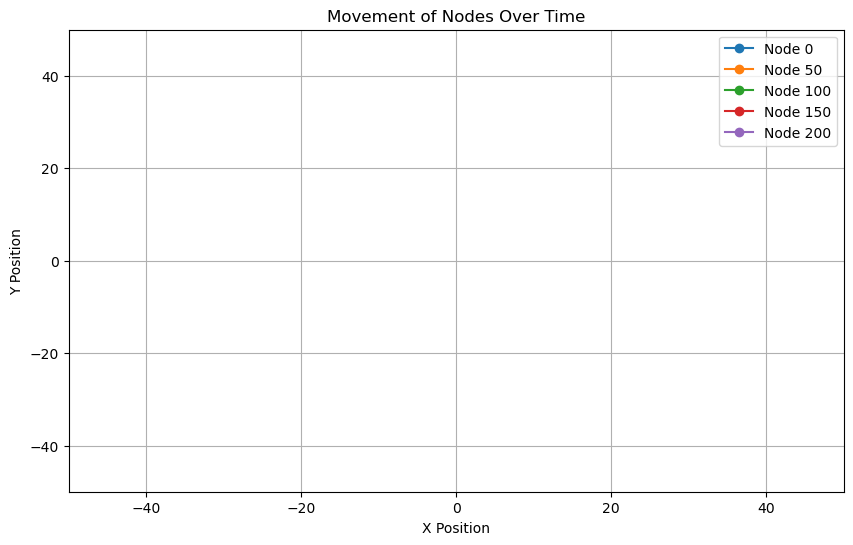

In [8]:
# 提取每 m 个节点的坐标
node_indices = range(0, num_segments, 50)  # 0-222, 自选

# 创建图形和轴对象
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-50, 50)  # 根据需要调整
ax.set_ylim(-50, 50)  # 根据需要调整
ax.set_title("Movement of Nodes Over Time")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.grid(True)

# 绘制线条和节点
lines = []
for node_idx in node_indices:
    (line,) = ax.plot([], [], marker="o", linestyle="-", label=f"Node {node_idx}")
    lines.append(line)


# 动画更新函数
def update(frame):
    for i, node_idx in enumerate(node_indices):
        x_coords = [positions[t][2 * node_idx] for t in range(frame)]
        y_coords = [positions[t][2 * node_idx + 1] for t in range(frame)]
        lines[i].set_data(x_coords, y_coords)
    return lines


# 创建动画
anim = FuncAnimation(fig, update, frames=len(positions), interval=100, blit=True)

# 显示动画
plt.legend()
plt.show()

# 保存数据

In [9]:
# 保存数据
# 创建数据字典
# position_data = {"Time_Step": []}
# velocity_data = {"Time_Step": []}
position_data = {}
velocity_data = {}

for i in range(num_segments):
    position_data[f"X_Node_{i}"] = []
    position_data[f"Y_Node_{i}"] = []
    velocity_data[f"Velocity_Node_{i}"] = []

for t in range(time_steps):
    # position_data["Time_Step"].append(t)
    # velocity_data["Time_Step"].append(t)
    for i in range(num_segments):
        position_data[f"X_Node_{i}"].append(positions[t][2 * i])
        position_data[f"Y_Node_{i}"].append(positions[t][2 * i + 1])
        velocity_data[f"Velocity_Node_{i}"].append(velocities[t][i])

# 创建 DataFrame
position_df = pd.DataFrame(position_data)
velocity_df = pd.DataFrame(velocity_data)

# 转置 DataFrame
position_df_transposed = position_df.T
velocity_df_transposed = velocity_df.T

# 定义输出文件路径
output_file_path = r"./result1.xlsx"

# 读取已有的表头和行名
# header=0 表示第一行作为列名, index_col=0 表示第一列作为行名
position_existing_df = pd.read_excel(
    output_file_path, sheet_name="位置", header=0, index_col=0
)
velocity_existing_df = pd.read_excel(
    output_file_path, sheet_name="速度", header=0, index_col=0
)

# 追加新数据并保持表头和行名
position_updated_df = pd.concat(
    [position_existing_df, position_df_transposed], ignore_index=False
)
velocity_updated_df = pd.concat(
    [velocity_existing_df, velocity_df_transposed], ignore_index=False
)

# 将更新后的数据写入到新的 Excel 文件
new_output_file_path = r"./result1.xlsx"
with pd.ExcelWriter(new_output_file_path, engine="openpyxl") as writer:
    position_updated_df.to_excel(writer, sheet_name="位置")
    velocity_updated_df.to_excel(writer, sheet_name="速度")

with pd.ExcelWriter(
    new_output_file_path, engine="openpyxl", mode="a", if_sheet_exists="overlay"
) as writer:
    position_df_transposed.to_excel(
        writer,
        sheet_name="位置",
        startrow=1,
        startcol=1,
        index=False,
        header=False,
    )
    velocity_df_transposed.to_excel(
        writer,
        sheet_name="速度",
        startrow=1,
        startcol=1,
        index=False,
        header=False,
    )

print(f"Data successfully saved to {new_output_file_path}")

Data successfully saved to ./result1.xlsx
